In [41]:
#
# In this notebook we compute simple statistics
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
from scipy.special import logit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from global_land_mask import globe
from src.regions import *
from src.pf_stats import *
from src.plotting import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
pf_stats = load_global_pf_stats()

## Example PFs
Generates side by side comparison of PFs based on example data downloaded from GPM

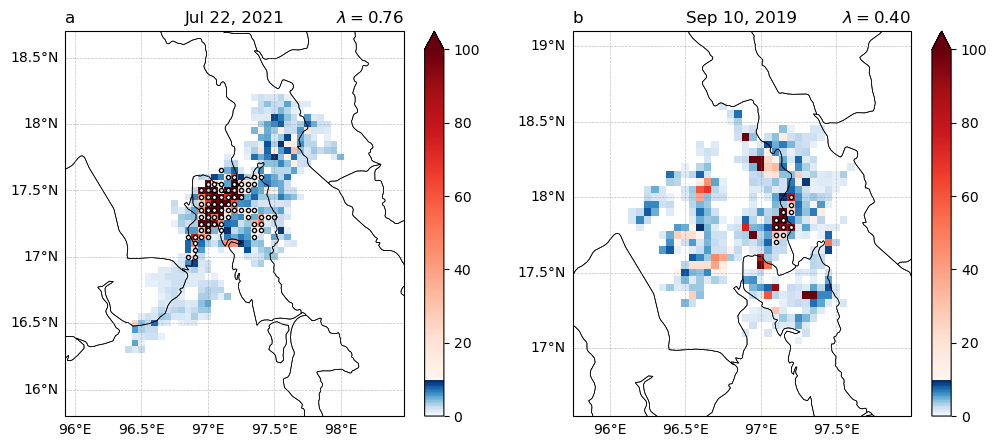

In [64]:
# Make colormap for features
def create_split_cmap(vmin=0, vmax=100, split=10,
                      cmap_low=plt.cm.Blues, cmap_high=plt.cm.Reds):
    """
    Create a custom colormap transitioning from cmap_low to cmap_high
    with 'split' as the boundary.
    """
    fraction = (split - vmin) / (vmax - vmin)
    n_total = 256
    n_low = int(n_total * fraction)
    n_high = n_total - n_low
    colors_low = cmap_low(np.linspace(0, 1, n_low))
    colors_high = cmap_high(np.linspace(0, 1, n_high))
    merged_colors = np.vstack((colors_low, colors_high))
    split_cmap = colors.ListedColormap(merged_colors, name="BluesToReds")
    split_norm = colors.Normalize(vmin=vmin, vmax=vmax)
    return split_cmap, split_norm


cmap_split, norm_split = create_split_cmap(
    vmin=0,
    vmax=100,
    split=10,
    cmap_low=plt.cm.Blues,
    cmap_high=plt.cm.Reds
)

fig, axs = plt.subplots(
    ncols=2,
    figsize=(12, 5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# We'll plot two examples: 'high_area_high_loc' and 'high_area_low_loc'
regimes = ['high_area_high_loc', 'high_area_low_loc']


for i, (ax_map, regime) in enumerate(zip(axs.ravel(), regimes)):
    # Ensure we keep a 1:1 lat/lon aspect ratio on both maps
    ax_map.set_aspect('equal', adjustable='datalim')

    # Load the example dataset
    pf_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}.nc'
    pf_data = xr.open_dataset(pf_filename)

    # Plot near_surf_rain
    rain_plot = pf_data.near_surf_rain.plot(
        ax=ax_map,
        cmap=cmap_split,
        norm=norm_split,
        cbar_kwargs={'label': None},
        transform=ccrs.PlateCarree()
    )

    # If lon/lat are 1D
    if 'lon' in pf_data.coords:
        lon = pf_data['lon'].values
    else:
        lon = pf_data['longitude'].values

    if 'lat' in pf_data.coords:
        lat = pf_data['lat'].values
    else:
        lat = pf_data['latitude'].values

    # Zoom to data
    buffer = 0.5
    ax_map.set_extent([lon.min()-buffer, lon.max()+buffer, lat.min()-buffer, lat.max()+buffer], ccrs.PlateCarree())

    # Label connected regions where rain > 10 mm/hr
    rain = pf_data.near_surf_rain.values
    mask = (rain > 10)
    structure = np.ones((3, 3))  # 8-connected
    labeled_array, num_features = ndimage.label(mask, structure=structure)

    if num_features > 0:
        region_sizes = ndimage.sum(mask, labeled_array, index=np.arange(1, num_features + 1))
        largest_region_label = np.argmax(region_sizes) + 1
        largest_region_mask = (labeled_array == largest_region_label)
        indices = np.argwhere(largest_region_mask)

        # Plot a marker for each cell in largest region
        for (i_idx, j_idx) in indices:
            ax_map.plot(
                lon[j_idx], lat[i_idx],
                marker='o', color='white', markersize=3, markeredgecolor='black',
                transform=ccrs.PlateCarree()
            )

    # Some features on the map
    ax_map.add_feature(cfeature.STATES, linewidth=0.5)
    ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)

    # Add quarter-degree lat/lon gridlines and labels
    gl = ax_map.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        alpha=0.5,
        linestyle='--'
    )
    # Turn off top/right labels if desired
    gl.top_labels = False
    gl.right_labels = False

    # Quarter-degree ticks
    gl.xlocator = mticker.MultipleLocator(0.5)
    gl.ylocator = mticker.MultipleLocator(0.5)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Panel labeling
    ax_map.set_title('')
    ax_map.set_title(chr(ord('a') + i), loc='left')

    # Title with date
    time_label = pf_data.time.dt.strftime('%b %d, %Y').item()
    ax_map.set_title(time_label)

    # Right-side subtitle with lambda
    lambda_val = [0.76, 0.40][i]  # HARDCODED VALUES FOR PLOTTING
    ax_map.set_title(rf'$\lambda={lambda_val:.2f}$', loc='right')

save_figure(fig, 'Examples of Precipitation Features of Different Localizations')


## PF MaxPr CDF
Makes CDF plot of maxpr and size

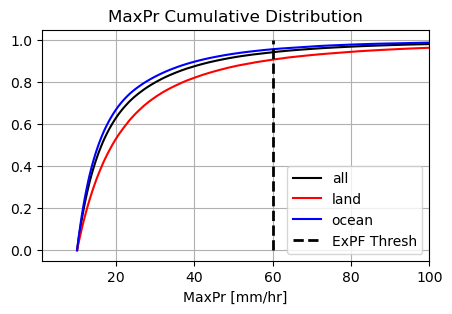

In [49]:
fig, ax = plt.subplots(figsize=(5,3))

maxpr = pf_stats['max_precip'].values
size = (pf_stats['num_pixels']*25).values

is_land_id = globe.is_land(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
is_ocean_id = globe.is_ocean(pf_stats['mean_latitude'], pf_stats['mean_longitude'])

def _plot_cdf(data, ax, label, color):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax.plot(np.sort(data), cdf, label=label, color=color)

_plot_cdf(maxpr, ax, 'all', 'black')
_plot_cdf(maxpr[is_land_id], ax, 'land', 'red')
_plot_cdf(maxpr[is_ocean_id], ax, 'ocean', 'blue')

ax.vlines(x=60, ymin=0, ymax=1, color='black', lw=2, linestyle='dashed', label='ExPF Thresh')
# ax2 = ax.twiny()
# _plot_cdf(size, ax2, 'all', 'black')

ax.set_xlim(1, 100)
ax.set_xlabel('MaxPr [mm/hr]')
ax.set_title('MaxPr Cumulative Distribution')
ax.grid()
ax.legend()
save_figure(fig, 'CDF of MaxPr for Land and Ocean PFs')

# ax2.set_xlim(10**(2.5), 1e4)
# ax2.set_xscale('log')
# ax2.set_xlabel('PF Area [km2]')


## Joint Distribution of MaxPr and Localization
Makes colored histogram of maxpr and localization for all, land, ocean, and thena  difference plot

Pearson r (All PFs): -0.3308, p-value: 0.0000e+00


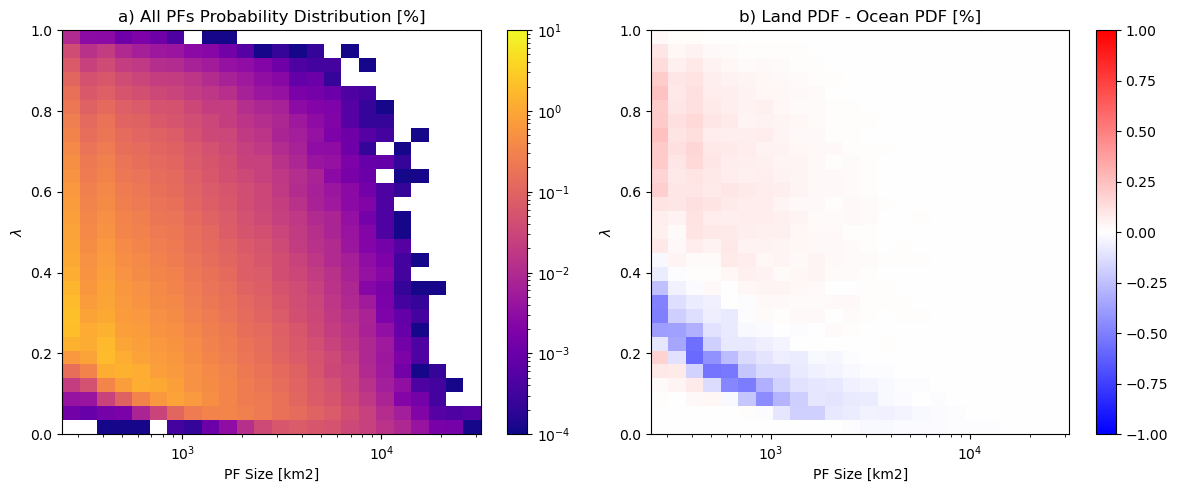

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

area = pf_stats['num_pixels'] * 25
loc = pf_stats['largest_10mmhr_cluster_precip_8conn'] / pf_stats['total_precip']

is_land_id = globe.is_land(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
is_ocean_id = globe.is_ocean(pf_stats['mean_latitude'], pf_stats['mean_longitude'])

area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
xx, yy = np.meshgrid(area_bins, loc_bins)

def _bin_count(loc_data, area_data):
    return binned_statistic_2d(
        x=loc_data,
        y=area_data,
        values=None,
        statistic='count',
        bins=[loc_bins, area_bins]
    ).statistic

# All
ax = axs[0]
count_all = _bin_count(loc, area)
r_val, p_val = pearsonr(area, loc)
print(f"Pearson r (All PFs): {r_val:.4f}, p-value: {p_val:.4e}")

pdf_all = 100 * count_all / count_all.sum()
c = ax.pcolormesh(xx, yy, pdf_all, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=1e-4, vmax=1e1))
ax.set_xscale('log')
ax.set_xlabel('PF Size [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('a) All PFs Probability Distribution [%]')
fig.colorbar(c, ax=ax)

# # Land
# ax = axs[1]
land_area = area[is_land_id]
land_loc = loc[is_land_id]
count_land = _bin_count(land_loc, land_area)
pdf_land = 100 * count_land / count_land.sum()
# c = ax.pcolormesh(xx, yy, pdf_land, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=1e-4, vmax=1e1))
# ax.set_xscale('log')
# ax.set_xlabel('PF Size [km2]')
# ax.set_ylabel(r'$\lambda$')
# ax.set_title('b) Land')
# fig.colorbar(c, ax=ax)

# # Ocean
# ax = axs[2]
ocean_area = area[is_ocean_id]
ocean_loc = loc[is_ocean_id]
count_ocean = _bin_count(ocean_loc, ocean_area)
pdf_ocean = 100 * count_ocean / count_ocean.sum()
# c = ax.pcolormesh(xx, yy, pdf_ocean, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=1e-4, vmax=1e1))
# ax.set_xscale('log')
# ax.set_xlabel('PF Size [km2]')
# ax.set_ylabel(r'$\lambda$')
# ax.set_title('c) Ocean')
# fig.colorbar(c, ax=ax)


# Difference (Land - Ocean)
ax = axs[1]
pdf_diff = pdf_land - pdf_ocean
c = ax.pcolormesh(
    xx, yy, pdf_diff, cmap=plt.cm.bwr,
    norm=colors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)
)
ax.set_xscale('log')
ax.set_xlabel('PF Size [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title(r'b) Land PDF - Ocean PDF [%]')
fig.colorbar(c, ax=ax)

fig.tight_layout(pad=1)
# fig.suptitle('Joint Probability Distributions [%]', y=1.05)

save_figure(fig, 'PDF of PF size and localization for all, land, and ocean')

## Localization and MaxPr
Plots mean statistics in morphological phase space

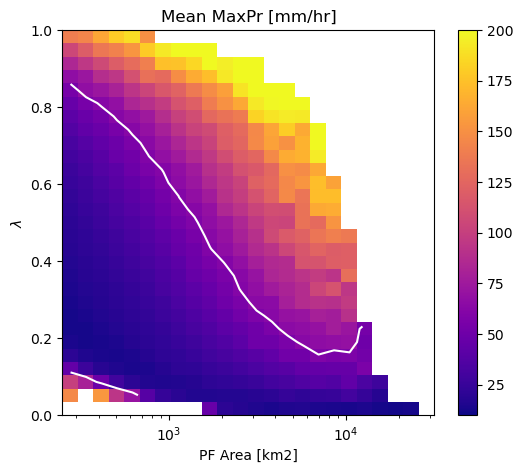

In [44]:
loc = pf_stats['largest_10mmhr_cluster_precip_8conn'] / pf_stats['total_precip']
area = pf_stats['num_pixels'] * 25
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
xx, yy = np.meshgrid(area_bins, loc_bins)


def _bin_mean(data, loc=loc, area=area, obs_thresh=10):
    stat = lambda x: np.nanmean(x) if x.size >= obs_thresh else np.nan
    mean = binned_statistic_2d(
        loc, 
        area,
        data.values, 
        bins=[loc_bins, area_bins],
        statistic=stat
    ).statistic
    return mean

mean_maxpr = _bin_mean(pf_stats['max_precip'])

fig, ax = plt.subplots(figsize=(6,5))
c = ax.pcolormesh(
    xx, yy,
    mean_maxpr,
    cmap=plt.cm.plasma,
    norm=colors.Normalize(vmin=10, vmax=200)
)

# Contour 60 mm/hr threshold
ax.contour(
    array_midpoints(area_bins),
    array_midpoints(loc_bins),
    mean_maxpr,
    [60],
    colors='white'
)

cb = fig.colorbar(c)

ax.set_xscale('log')
ax.set_xlabel('PF Area [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('Mean MaxPr [mm/hr]')

save_figure(fig, 'Mean MaxPr for all PFs white 60mmhr contour')

## Localization and Area Frac PDF
Generates PDF of PF localization (precipitation) and PC area frac (area)

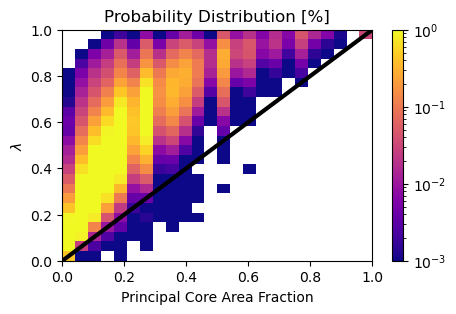

In [94]:
area_frac = pf_stats['largest_10mmhr_cluster_size_8conn']/pf_stats['num_pixels']
loc = pf_stats['largest_10mmhr_cluster_precip_8conn']/pf_stats['total_precip']

area_frac_bins = np.linspace(0, 1, 25)
loc_bins = np.linspace(0, 1, 25)
xx, yy = np.meshgrid(area_frac_bins, loc_bins)

fig, ax = plt.subplots(figsize=(5,3))

count = binned_statistic_2d(
    loc, 
    area_frac, 
    None, 
    bins=[loc_bins, area_frac_bins],
    statistic='count'
).statistic

c = ax.pcolormesh(
    xx,
    yy,
    100*count/count.sum(),
    cmap=plt.cm.plasma,
    norm=colors.LogNorm(vmin=1e-3, vmax=1e0)
)

cb = fig.colorbar(c)

ax.plot([0,1], [0,1], lw=3, color='k')
ax.set_xlabel('Principal Core Area Fraction')
ax.set_ylabel(r'$\lambda$')
ax.set_title('Probability Distribution [%]')

save_figure(fig, 'Localization and Principal Core area ')

## Number of PFs with MaxPr in Principal Core

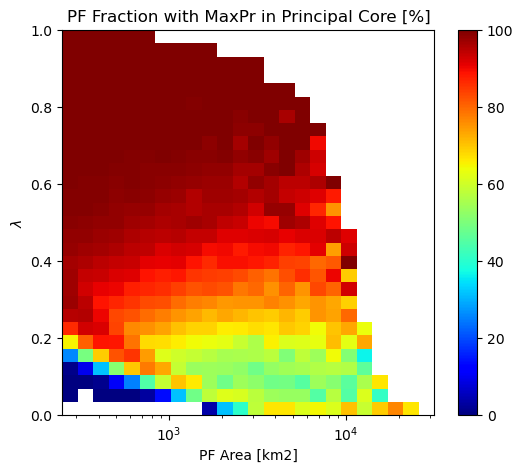

In [124]:
loc = pf_stats['largest_10mmhr_cluster_precip_8conn'] / pf_stats['total_precip']
area = pf_stats['num_pixels'] * 25
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
xx, yy = np.meshgrid(area_bins, loc_bins)


def _bin_sum(data, loc=loc, area=area, obs_thresh=10):
    stat = lambda x: np.nansum(x) if x.size >= obs_thresh else np.nan
    sum = binned_statistic_2d(
        loc, 
        area,
        data.values, 
        bins=[loc_bins, area_bins],
        statistic=stat
    ).statistic

    return sum
def _bin_count(data, loc=loc, area=area, obs_thresh=10):
    sum = binned_statistic_2d(
        loc, 
        area,
        None, 
        bins=[loc_bins, area_bins],
        statistic='count'
    ).statistic
    
    return sum

max_in_pc = (
    (pf_stats['max_precip']==pf_stats['largest_10mmhr_cluster_max_precip_8conn'])
)

total_number_of_systems = _bin_count(max_in_pc)
total_number_of_max_in_pc_systems = _bin_sum(max_in_pc)
frac = total_number_of_max_in_pc_systems/total_number_of_systems
fig, ax = plt.subplots(figsize=(6,5))
c = ax.pcolormesh(
    xx, yy,
    100*frac,
    cmap=plt.cm.jet,
    norm=colors.Normalize(vmin=0, vmax=100)
)

cb = fig.colorbar(c)

ax.set_xscale('log')
ax.set_xlabel('PF Area [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('PF Fraction with MaxPr in Principal Core [%]')

save_figure(fig, 'Fraction of Principal MaxPr Cores')